In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from awesome.run.functions import *

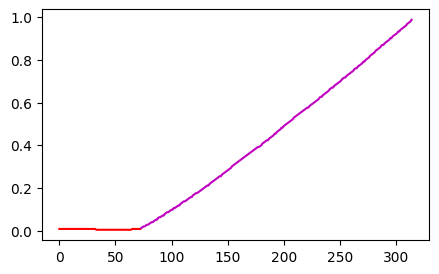

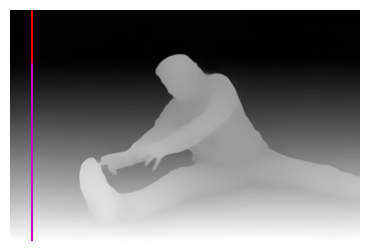

In [3]:
img_dir="depth.png"
img_pil=Image.open(img_dir)
width, height = img_pil.size 
newsize = (int(width/2), int(height/2))
img_pil_orig = img_pil.resize(newsize)


img_dir="depth_scribbles.png"
img_pil=Image.open(img_dir)
newsize = (int(width/2), int(height/2))
img_pil = img_pil.resize(newsize)

img= np.array(img_pil, dtype='float')/255.0
img = img[:,:,0:3]
nx,ny,nc = img.shape
mask_fg = torch.tensor(img[:,:,0]-img[:,:,1])>0.1
mask_bg = torch.tensor(img[:,:,0]-img[:,:,1])<-0.1


img= np.array(img_pil_orig, dtype='float')/255.0
#img = np.mean(img, axis=2)
nx,ny = img.shape

fig = plt.figure(figsize=(5,3))
plt.plot(np.array(range(73)),img[0:73,30], 'r-')
plt.plot(np.array(range(73,nx,1)),img[73:,30], 'm-')
#plt.imshow(img)
#plt.colorbar()
plt.savefig('depth_values_along_line.png',bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(5,3))
plt.imshow(img, cmap='gray')
plt.plot(np.ones(73)*30, np.array(range(73)),'r-')
plt.plot(np.ones(nx-73)*30, np.array(range(73,nx,1)),'m-')
#plt.colorbar()
plt.axis('off')
plt.savefig('cut.png',bbox_inches='tight')
plt.show()

In [32]:
class myConvexNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.W0y = nn.Linear(3, n_hidden)
        self.W1z = nn.Linear(n_hidden, n_hidden)
        self.W2z = nn.Linear(n_hidden, 1)
        
        # something skippy
        self.W1y = nn.Linear(3, n_hidden,bias=False)
        self.W2y = nn.Linear(3, 1,bias=False)
        
    def forward(self, x):
        # define forward pass
        x_input = x
        x = F.relu(self.W0y(x))
        x = F.relu(self.W1z(x) + self.W1y(x_input))
        x = self.W2z(x) + self.W2y(x_input)
        return x
    

In [33]:
def extractInformationFromLikelihood(likelihood, mask):
    indices = torch.nonzero(mask)
    N_fore = indices.shape[0]
    print(N_fore)
    pixel_info = torch.zeros((N_fore,2)) # store x,y values of all pixels the user marked as foreground

    labels = torch.zeros(N_fore)
    pixel_info[:,0] = indices[:,0] / nx -0.5
    pixel_info[:,1] = indices[:,1] / ny -0.5
    labels = likelihood[mask]
    return pixel_info, labels


pix_back,labels_back = extractInformationFromLikelihood(torch.tensor(img), mask_bg)
pix_fore,labels_fore = extractInformationFromLikelihood(torch.tensor(img), mask_fg)

bg = torch.cat((pix_back,labels_back[:,None]), dim=1)
fg = torch.cat((pix_fore,labels_fore[:,None]), dim=1)

pix = torch.cat((bg,fg),dim=0)
pix = pix.type(torch.float)
labels = torch.zeros(pix.shape[0])
labels[0:bg.shape[0]]=1
labels = labels.type(torch.float)

581
673


In [39]:
convexNet = myConvexNet(50)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(convexNet.parameters(), lr=1e-2)  
num_epochs = 5000
number = 500

print(pix.shape, labels.shape)
# Train the model
for epoch in range(num_epochs):
    perm = torch.randperm(pix_back.size(0))
    idx = perm[:number]
    random_pix_back = torch.cat((pix_back[idx,:],labels_back[idx][:,None]), dim=1).float()
    
    perm = torch.randperm(pix_fore.size(0))
    idx = perm[:number]
    random_pix_fore = torch.cat((pix_fore[idx,:],labels_fore[idx][:,None]), dim=1).float()
    
    if False:
        outputs_back = torch.sigmoid(convexNet(random_pix_back)).squeeze()
        outputs_fore = torch.sigmoid(convexNet(random_pix_fore)).squeeze()
        loss = 1.0*criterion(outputs_back, torch.ones(random_pix_back.shape[0])) + 5.*criterion(outputs_fore, torch.zeros(random_pix_fore.shape[0]))

    if True:
        out = torch.sigmoid(convexNet(pix)).squeeze()
        loss = 1.0*criterion(out, 1-labels) 
        
    # Backprpagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        convexNet.W1z.weight.data = F.relu(convexNet.W1z.weight.data)
        convexNet.W2z.weight.data = F.relu(convexNet.W2z.weight.data)

    if (epoch+1) % 500 == 0:
        print ('Epoch [{}/{}],  Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))

torch.Size([1254, 3]) torch.Size([1254])
Epoch [500/5000],  Loss: 0.0000
Epoch [1000/5000],  Loss: 0.0000
Epoch [1500/5000],  Loss: 0.0000
Epoch [2000/5000],  Loss: 0.0000
Epoch [2500/5000],  Loss: 0.0000
Epoch [3000/5000],  Loss: 0.0000
Epoch [3500/5000],  Loss: 0.0000
Epoch [4000/5000],  Loss: 0.0000
Epoch [4500/5000],  Loss: 0.0000
Epoch [5000/5000],  Loss: 0.0000


149940


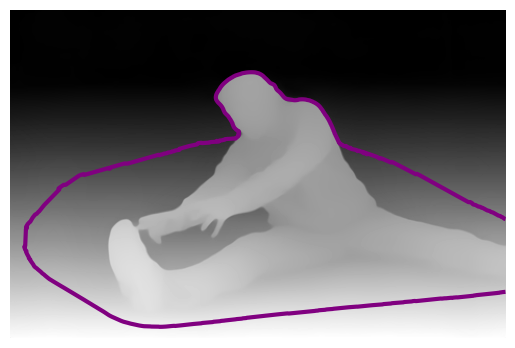

In [41]:
allPixels,temp = extractInformationFromLikelihood(torch.tensor(img),  torch.ones((nx,ny))>0.5)

alle = torch.cat((allPixels,temp[:,None]), dim=1)
alle = alle.type(torch.float)

inferenceResult = convexNet(alle) # torch tensor of size nx*ny
inferenceResult = inferenceResult.detach().numpy().reshape((nx,ny))
thresh = 0.0
im = Image.fromarray(255*(inferenceResult<thresh).astype('uint8'))
#im.save("mask_no_convexity.png")

plt.imshow(img, cmap='gray')
plt.contour(inferenceResult, levels=[thresh], colors='purple',linewidths=3)
#plt.imshow(inferenceResult<0.5, cmap='binary', alpha=0.7)
#plt.colorbar()
plt.plot(np.array(range(ny)), 73*np.ones(ny),'g--')
plt.axis('off')
#plt.savefig('without_convexity.png',bbox_inches='tight')
plt.show()


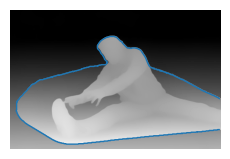

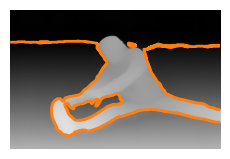

In [9]:

mask_path = './original/mask_ours.png'
orig_mask = load_mask_single_channel(mask_path) / 255


mask_path_naive = './original/mask_no_convexity.png'
likelihood = load_mask_single_channel(mask_path_naive) / 255

crop_y = slice(0, img.shape[0])
crop_x = slice(0, img.shape[1])

constraint_name = "convex"
image_name = "depth"
path = "./new/"
target_px = 952
target_py = 630
actual_px = (crop_x.stop - crop_x.start)
actual_py = (crop_y.stop - crop_y.start)
# Recalculate crop start to get same aspect ratio as target_px and target_py
aspect = target_px / target_py
new_start = int(max(crop_x.start + ((actual_px - actual_py * aspect) / 2), 0))
crop_x = slice(int(new_start), int(actual_px * aspect + new_start))
actual_px = (crop_x.stop - crop_x.start)

naive = 1 - likelihood[crop_y, crop_x]
constraint = 1 - orig_mask[crop_y, crop_x]
pimg = img[crop_y, crop_x]
size = target_px / actual_px

darkening = 0.3

def resize_img(path, target_px, target_py):
    img = Image.open(path)
    img = img.resize((target_px, target_py))
    img.save(path)

cmap="gray"

color = plt.get_cmap('tab10')(0)
save_path = path + f"{image_name}_{constraint_name}_naive.png"
plot_mask(pimg, naive, image_cmap=cmap, contour_linewidths=1, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True, darkening_background=darkening)
resize_img(save_path, target_px, target_py)

color = plt.get_cmap('tab10')(1)
save_path = path + f"{image_name}_{constraint_name}.png"
plot_mask(pimg, constraint, image_cmap=cmap, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True, darkening_background=darkening)
resize_img(save_path, target_px, target_py)